# Notebook 5.1: Modeling a Fed-Batch Bioreactor

Welcome to Part 5 of our series: Bioreactor Case Studies! In this notebook, we shift our focus from generic examples to a more complex and industrially relevant application: the **fed-batch bioreactor**. These systems are widely used for producing therapeutic proteins, such as monoclonal antibodies (mAbs), using mammalian cell cultures (e.g., CHO cells).

The dynamics of a bioreactor are inherently nonlinear due to complex biological kinetics. This notebook will focus on developing a mathematical model for a simplified fed-batch bioreactor, which will serve as the "plant" for our subsequent NMPC design notebooks (5.2 and 5.3).

**Goals of this Notebook:**
1. Briefly introduce the concept of fed-batch bioreactors for mAb production.
2. Define a set of nonlinear Ordinary Differential Equations (ODEs) representing key process variables (e.g., cell density, substrate, product, volume).
3. Implement common nonlinear kinetic expressions for cell growth, substrate consumption, and product formation.
4. Simulate the open-loop behavior of this bioreactor model using `scipy.integrate.solve_ivp` under different pre-defined feeding strategies.
5. Visualize and analyze the dynamic trajectories of the key state variables.
6. Explore the sensitivity of the batch outcome to changes in key kinetic parameters.

## 1. Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ipywidgets import interact, FloatSlider, IntSlider # For interactive plots

# Optional: for nicer plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 8)})

## 2. Introduction to Fed-Batch Bioreactors

A fed-batch bioreactor operation typically involves:
1.  **Initial Batch Phase:** Cells are inoculated into a starting volume of medium containing essential nutrients.
2.  **Fed-Batch Phase:** As cells grow and consume nutrients, concentrated feed solutions are added to the reactor over time. This replenishes depleted nutrients, sustains cell growth and viability, and promotes product formation. The reactor volume increases during this phase.
3.  **Harvest:** The process ends when product concentration is maximized, cell viability drops significantly, or a pre-determined batch time is reached.

**Key Variables to Model:**
-   $X_v$: Viable Cell Density (e.g., cells/mL or g/L)
-   $S$: Concentration of a limiting substrate (e.g., Glucose, g/L)
-   $P$: Concentration of the desired product (e.g., mAb, g/L)
-   $V$: Volume of the culture in the bioreactor (L)

**Manipulated Variable (Input):**
-   $F_{in}$: Feed rate of the nutrient solution (L/hr or L/day)

## 3. Bioreactor Model Equations (ODEs)

We'll define a system of ODEs based on mass balances. The states are $[X_v, S, P, V]$.

1.  **Volume Balance:**
    $$ \frac{dV}{dt} = F_{in} $$

2.  **Viable Cell Density ($X_v$) Balance:**
    $$ \frac{dX_v}{dt} = (\mu - \mu_d) X_v - \frac{F_{in}}{V} X_v $$
    where $\mu$ is the specific growth rate and $\mu_d$ is the specific death rate. The last term accounts for dilution due to feeding.

3.  **Substrate ($S$) Balance:**
    $$ \frac{dS}{dt} = -q_S X_v + \frac{F_{in}}{V} (S_{feed} - S) $$
    where $q_S$ is the specific substrate consumption rate, and $S_{feed}$ is the substrate concentration in the feed solution. The last term accounts for dilution and substrate addition.

4.  **Product ($P$) Balance:**
    $$ \frac{dP}{dt} = q_P X_v - \frac{F_{in}}{V} P $$
    where $q_P$ is the specific product formation rate. The last term accounts for dilution.

### Kinetic Rate Expressions:

*   **Specific Growth Rate ($\mu$):** We'll use Monod kinetics for substrate limitation.
    $$ \mu = \mu_{max} \frac{S}{K_S + S} $$ 
    (We could add inhibition terms for byproducts later if needed).

*   **Specific Death Rate ($\mu_d$):** For simplicity, let's assume a constant specific death rate for now, or one dependent on substrate limitation.
    $$ \mu_d = k_d + k_{d,S} \frac{K_{d,S}}{K_{d,S} + S} $$ 
    (Increases as substrate becomes very low).

*   **Specific Substrate Consumption Rate ($q_S$):** Substrate is consumed for growth, product formation (if applicable), and cell maintenance.
    $$ q_S = \frac{\mu}{Y_{X/S}} + m_S + \frac{q_P}{Y_{P/S}} $$ 
    where $Y_{X/S}$ is the yield of biomass from substrate, $m_S$ is the maintenance coefficient, and $Y_{P/S}$ is the yield of product from substrate (if product synthesis consumes $S$ beyond what's used for growth/maintenance).

*   **Specific Product Formation Rate ($q_P$):** We'll use a Luedeking-Piret type model, relating product formation to both growth and biomass concentration.
    $$ q_P = \alpha \mu + \beta $$ 
    where $\alpha$ is the growth-associated coefficient and $\beta$ is the non-growth-associated coefficient.

In [2]:
# Define the Bioreactor Model ODE function
def bioreactor_ode(t, states, params, F_in_func):
    Xv, S, P, V = states # Unpack current states
    
    # Get parameters
    mu_max = params['mu_max']
    K_S = params['K_S']
    k_d = params['k_d']
    k_d_S = params['k_d_S'] # Additional death rate due to low substrate
    K_d_S_coeff = params['K_d_S_coeff'] # Substrate level at which this death rate is half max
    Y_XS = params['Y_XS'] # Yield of biomass from substrate
    m_S = params['m_S']   # Maintenance coefficient
    alpha = params['alpha'] # Growth-associated product formation
    beta = params['beta']   # Non-growth-associated product formation
    Y_PS = params['Y_PS']   # Yield of product from substrate (set to large if no direct consumption for P)
    S_feed = params['S_feed'] # Substrate concentration in feed

    # Get current feed rate F_in(t)
    F_in = F_in_func(t)
    
    # --- Kinetic Rate Calculations ---
    # Specific growth rate (Monod)
    mu = mu_max * S / (K_S + S + 1e-9) # Add small epsilon to avoid division by zero if S=0 and K_S=0
    
    # Specific death rate
    mu_d = k_d + k_d_S * K_d_S_coeff / (K_d_S_coeff + S + 1e-9)
    
    # Specific product formation rate (Luedeking-Piret)
    q_P = alpha * mu + beta
    
    # Specific substrate consumption rate
    if Y_PS == 0 or Y_PS is None or Y_PS > 1e6: # effectively Y_PS is infinity
        q_S = (mu / (Y_XS + 1e-9)) + m_S
    else:
        q_S = (mu / (Y_XS + 1e-9)) + m_S + (q_P / (Y_PS + 1e-9))

    # --- ODEs ---
    if V < 1e-6: # Avoid division by zero if volume is tiny
        dXv_dt = 0
        dS_dt = 0
        dP_dt = 0
        dV_dt = F_in
    else:
        dilution_rate = F_in / V
        
        dXv_dt = (mu - mu_d) * Xv - dilution_rate * Xv
        dS_dt = -q_S * Xv + dilution_rate * (S_feed - S)
        dP_dt = q_P * Xv - dilution_rate * P
        dV_dt = F_in
    
    # Ensure states remain non-negative (simple clamping, more advanced handling might be needed)
    # This is more of a numerical stability check for the ODE solver
    # if Xv < 0 and dXv_dt < 0: dXv_dt = 0
    # if S < 0 and dS_dt < 0: dS_dt = 0 
    # if P < 0 and dP_dt < 0: dP_dt = 0
    # Better to handle this by ensuring kinetics make sense at S=0 etc.

    return [dXv_dt, dS_dt, dP_dt, dV_dt]

# Define a default set of parameters
default_params = {
    'mu_max': 0.08,    # 1/hr (max specific growth rate)
    'K_S': 0.1,       # g/L (Monod constant for substrate)
    'k_d': 0.005,     # 1/hr (specific death rate)
    'k_d_S': 0.02,    # 1/hr (additional death rate factor at low S)
    'K_d_S_coeff': 0.01, # g/L (substrate level for half of k_d_S effect)
    'Y_XS': 0.5,      # g Xv / g S (yield of biomass from substrate)
    'm_S': 0.01,      # g S / g Xv / hr (maintenance coefficient)
    'alpha': 0.01,    # g P / g Xv (growth-associated product formation)
    'beta': 0.002,    # g P / g Xv / hr (non-growth-associated product formation)
    'Y_PS': 1e9,      # g P / g S (yield of product from substrate - effectively infinity here)
    'S_feed': 200.0   # g/L (substrate concentration in feed)
}

## 4. Simulating Open-Loop Behavior

Let's simulate the bioreactor under different feeding strategies using `scipy.integrate.solve_ivp`.

In [3]:
# Simulation settings
t_start = 0      # hr
t_end = 240      # hr (e.g., 10 days)
t_eval = np.linspace(t_start, t_end, 200) # Time points for ODE solver output

# Initial conditions
Xv0 = 0.1 # g/L (initial viable cell density)
S0 = 5.0  # g/L (initial substrate concentration)
P0 = 0.0  # g/L (initial product concentration)
V0 = 1.0  # L (initial volume)
initial_states = [Xv0, S0, P0, V0]

# --- Define different feeding strategies --- 
def feed_profile_batch(t):
    "No feed." 
    return 0.0

def feed_profile_constant(t, F_const=0.005):
    "Constant feed rate (L/hr)."
    return F_const # e.g., 0.005 L/hr

def feed_profile_bolus(t, t_bolus=[48, 96], V_bolus=0.05):
    # Bolus feeds at specific times.
    # Approximated by a high feed rate over a short duration (e.g., 1 hr).
    # solve_ivp handles events better, but for simplicity we use time-dependent F_in.
    
    feed = 0.0
    for tb in t_bolus:
        if tb <= t < tb + 1.0: # Bolus over 1 hour
            feed = V_bolus # L/hr (so total V_bolus is added)
    return feed

# --- Function to run and plot simulation ---
def run_and_plot_bioreactor(feed_func, params, title_suffix=""):
    sol = solve_ivp(bioreactor_ode, 
                      [t_start, t_end], 
                      initial_states, 
                      args=(params, feed_func),
                      dense_output=True, 
                      t_eval=t_eval,
                      method='LSODA' # Good for stiff problems
                     )
    
    Xv_sim, S_sim, P_sim, V_sim = sol.y
    t_sim = sol.t
    
    # Calculate actual feed profile applied by F_in_func over t_sim
    F_in_sim = np.array([feed_func(ti) for ti in t_sim])
    
    fig, axs = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    fig.suptitle(f'Bioreactor Simulation: {title_suffix}', fontsize=16)
    
    # Plot Xv and P
    ax0_twin = axs[0].twinx()
    axs[0].plot(t_sim, Xv_sim, 'b-', label='$X_v$ (g/L)')
    ax0_twin.plot(t_sim, P_sim, 'r--', label='$P_{prod}$ (g/L)')
    axs[0].set_ylabel('$X_v$ (g/L)', color='b')
    ax0_twin.set_ylabel('$P_{prod}$ (g/L)', color='r')
    axs[0].tick_params(axis='y', labelcolor='b')
    ax0_twin.tick_params(axis='y', labelcolor='r')
    axs[0].grid(True); axs[0].legend(loc='upper left'); ax0_twin.legend(loc='upper right')

    # Plot S and V
    ax1_twin = axs[1].twinx()
    axs[1].plot(t_sim, S_sim, 'g-', label='$S_{glc}$ (g/L)')
    ax1_twin.plot(t_sim, V_sim, 'm--', label='$V$ (L)')
    axs[1].set_ylabel('$S_{glc}$ (g/L)', color='g')
    ax1_twin.set_ylabel('$V$ (L)', color='m')
    axs[1].tick_params(axis='y', labelcolor='g')
    ax1_twin.tick_params(axis='y', labelcolor='m')
    axs[1].set_ylim(bottom=0) # Ensure substrate doesn't go visually negative if small values
    ax1_twin.set_ylim(bottom=0)
    axs[1].grid(True); axs[1].legend(loc='center left'); ax1_twin.legend(loc='center right')
    
    # Plot F_in
    axs[2].plot(t_sim, F_in_sim, 'k-', label='$F_{in}$ (L/hr)')
    axs[2].set_ylabel('$F_{in}$ (L/hr)')
    axs[2].set_xlabel('Time (hr)')
    axs[2].grid(True); axs[2].legend(loc='upper right')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.show()
    
    print(f"Final conditions for {title_suffix}:")
    print(f"  Xv = {Xv_sim[-1]:.3f} g/L")
    print(f"  S  = {S_sim[-1]:.3f} g/L")
    print(f"  P  = {P_sim[-1]:.3f} g/L")
    print(f"  V  = {V_sim[-1]:.3f} L")
    print(f"  Total Product = {P_sim[-1] * V_sim[-1]:.3f} g")

#### Simulation 1: Batch Operation (No Feed)

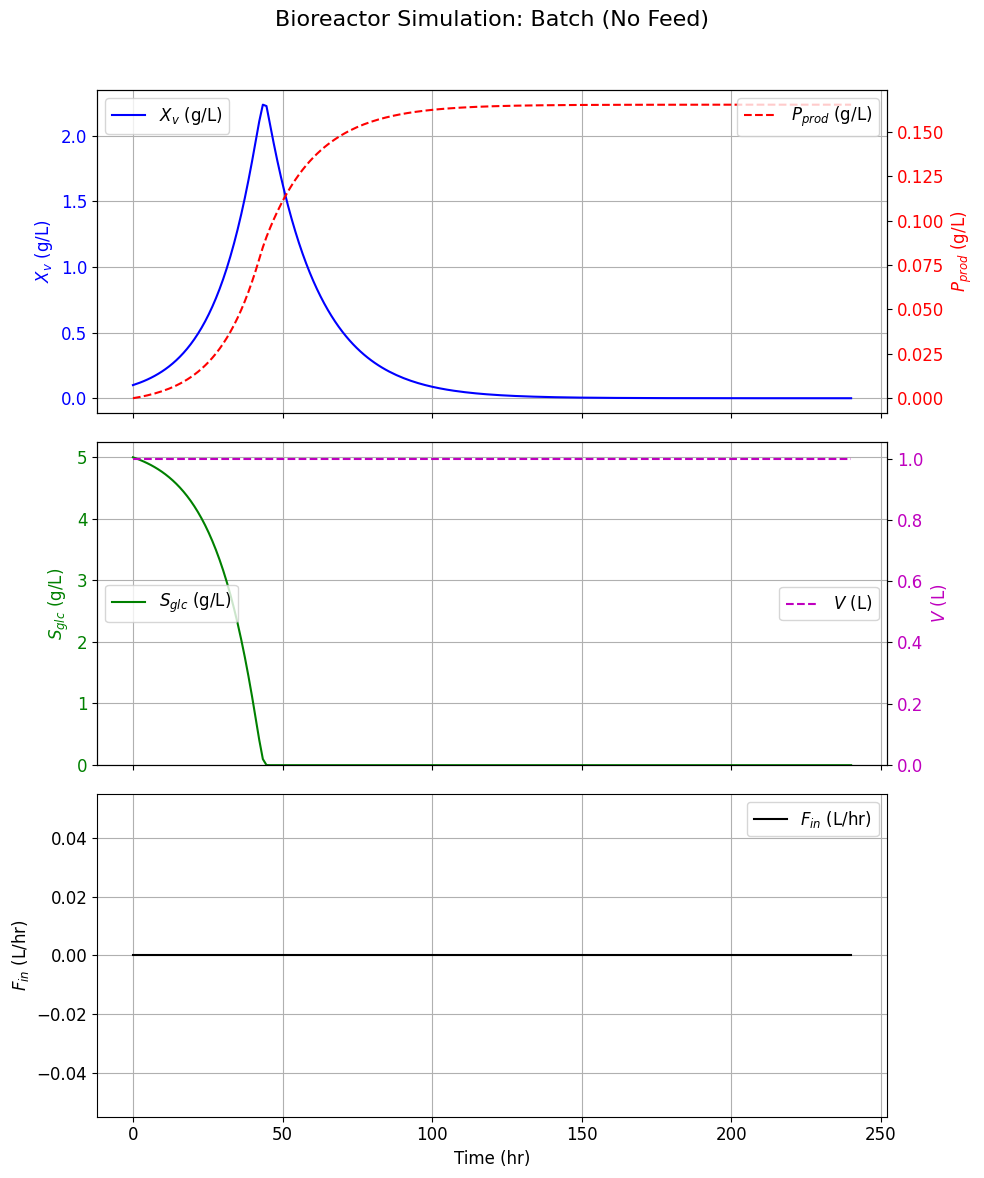

Final conditions for Batch (No Feed):
  Xv = 0.000 g/L
  S  = -0.006 g/L
  P  = 0.165 g/L
  V  = 1.000 L
  Total Product = 0.165 g


In [4]:
run_and_plot_bioreactor(feed_profile_batch, default_params, title_suffix="Batch (No Feed)")

#### Simulation 2: Constant Feed

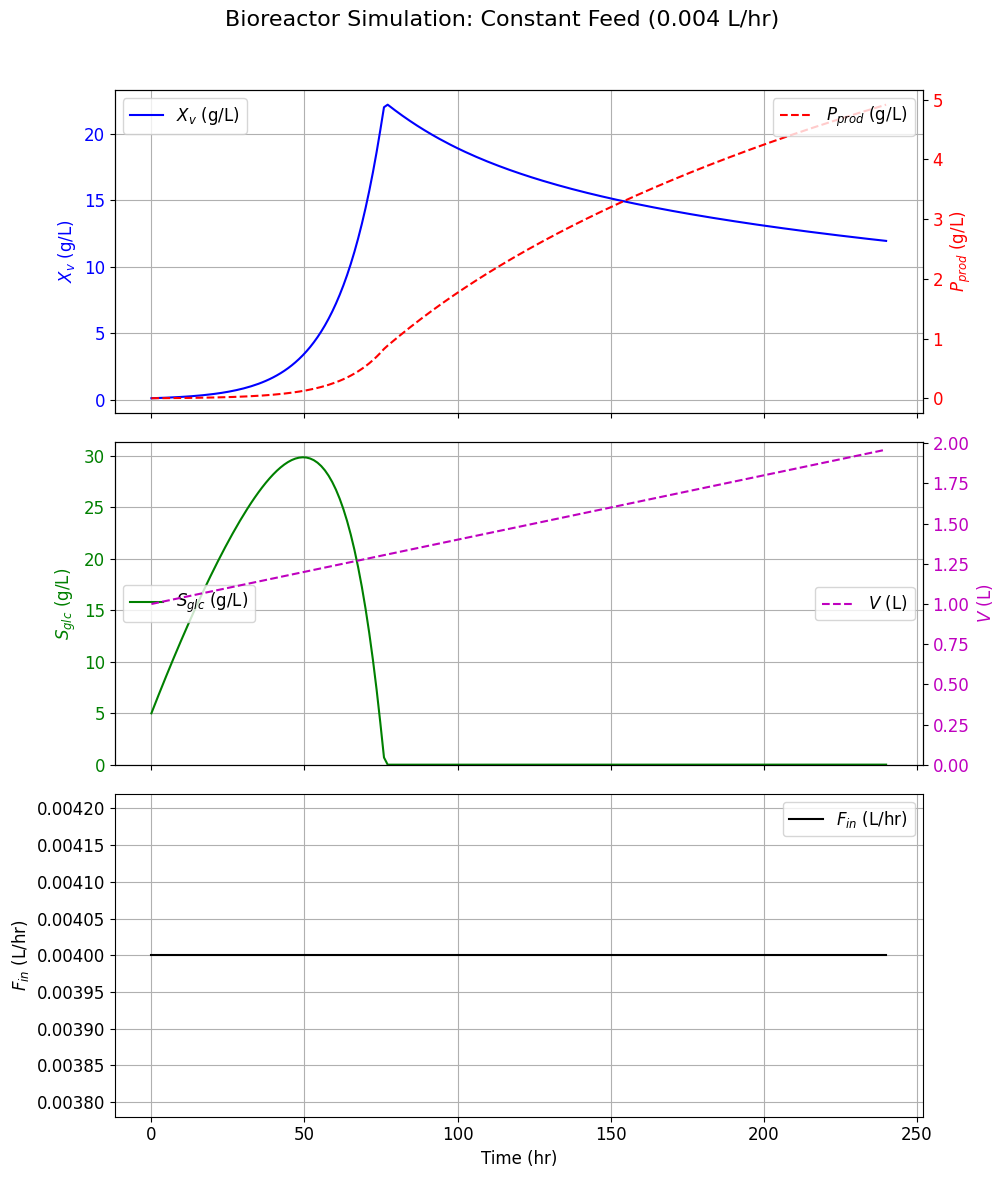

Final conditions for Constant Feed (0.004 L/hr):
  Xv = 11.932 g/L
  S  = 0.018 g/L
  P  = 4.917 g/L
  V  = 1.960 L
  Total Product = 9.637 g


In [5]:
F_const_val = 0.004 # L/hr
run_and_plot_bioreactor(lambda t: feed_profile_constant(t, F_const=F_const_val), 
                        default_params, 
                        title_suffix=f"Constant Feed ({F_const_val} L/hr)")

#### Simulation 3: Bolus Feeds

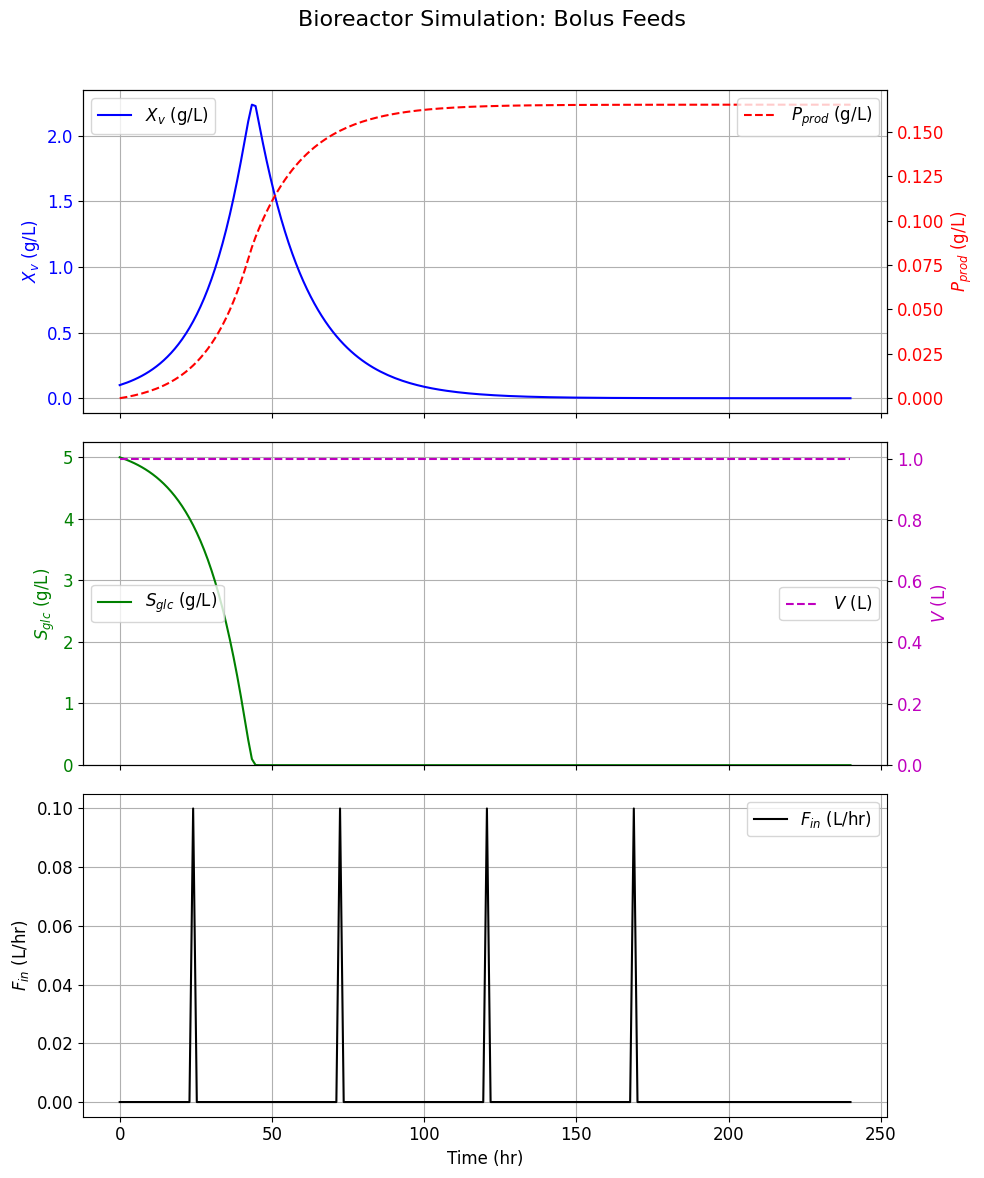

Final conditions for Bolus Feeds:
  Xv = 0.000 g/L
  S  = -0.006 g/L
  P  = 0.165 g/L
  V  = 1.000 L
  Total Product = 0.165 g


In [6]:
bolus_times = [24, 72, 120, 168] # hr
bolus_volume_per_shot = 0.1 # L
run_and_plot_bioreactor(lambda t: feed_profile_bolus(t, t_bolus=bolus_times, V_bolus=bolus_volume_per_shot), 
                        default_params, 
                        title_suffix=f"Bolus Feeds")

## 5. Interactive Parameter Sensitivity Analysis

Let's use `ipywidgets` to see how changing key kinetic parameters affects the batch outcome for a chosen feeding strategy (e.g., constant feed).

In [ ]:
def interactive_bioreactor_plot(mu_max_val, K_S_val, Y_XS_val, alpha_val, beta_val, F_const_val):
    current_params = default_params.copy()
    current_params['mu_max'] = mu_max_val
    current_params['K_S'] = K_S_val
    current_params['Y_XS'] = Y_XS_val
    current_params['alpha'] = alpha_val
    current_params['beta'] = beta_val
    
    run_and_plot_bioreactor(lambda t: feed_profile_constant(t, F_const=F_const_val), 
                            current_params, 
                            title_suffix=f"Interactive Constant Feed ({F_const_val:.3f} L/hr)")

interact(interactive_bioreactor_plot,
         mu_max_val=FloatSlider(min=0.01, max=0.2, step=0.01, value=default_params['mu_max'], description='μ_max (1/hr)'),
         K_S_val=FloatSlider(min=0.01, max=1.0, step=0.01, value=default_params['K_S'], description='K_S (g/L)'),
         Y_XS_val=FloatSlider(min=0.1, max=1.0, step=0.05, value=default_params['Y_XS'], description='Y_XS (gX/gS)'),
         alpha_val=FloatSlider(min=0.0, max=0.1, step=0.001, value=default_params['alpha'], description='α (gP/gX)'),
         beta_val=FloatSlider(min=0.0, max=0.01, step=0.0001, value=default_params['beta'], format='.4f', description='β (gP/gX/hr)'),
         F_const_val=FloatSlider(min=0.0, max=0.01, step=0.0005, value=0.004, format='.4f', description='F_const (L/hr)')
        );

interactive(children=(FloatSlider(value=0.08, description='μ_max (1/hr)', max=0.2, min=0.01, step=0.01), Float…

## 6. Key Takeaways

*   Fed-batch bioreactor dynamics are governed by coupled, nonlinear ODEs describing mass balances and biological kinetics.
*   Kinetic expressions (Monod, Luedeking-Piret, etc.) capture the complex relationships between cell growth, substrate consumption, and product formation.
*   The choice of feeding strategy ($F_{in}(t)$) dramatically impacts the batch trajectory and final outcome (e.g., product titer).
*   The process is sensitive to kinetic parameters, highlighting the need for accurate parameter estimation if the model is to be used for predictive control.
*   This simulated bioreactor model, despite its simplifications compared to real CHO cell cultures, provides a good testbed for developing and evaluating NMPC strategies.

In the next notebook (**Notebook 5.2: NMPC for Fed-Batch Bioreactor - Setpoint Tracking**), we will design an NMPC controller to regulate a key variable (like glucose concentration) in this bioreactor model by manipulating the feed rate.